#Imports

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download mahmoudreda55/satellite-image-classification


 73% 16.0M/21.8M [00:00<00:00, 167MB/s]
100% 21.8M/21.8M [00:00<00:00, 186MB/s]


In [3]:
! unzip /content/satellite-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

In [4]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

#Data Loader

In [6]:
folder_path = "/content/data"
contents = os.listdir(folder_path)
print(contents)

['water', 'cloudy', 'green_area', 'desert']


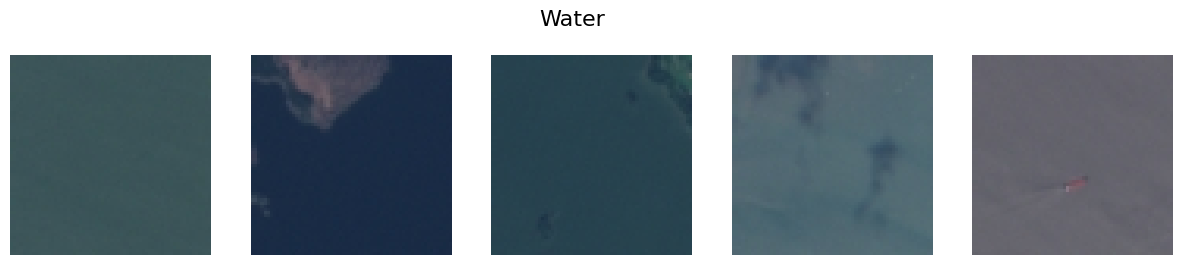

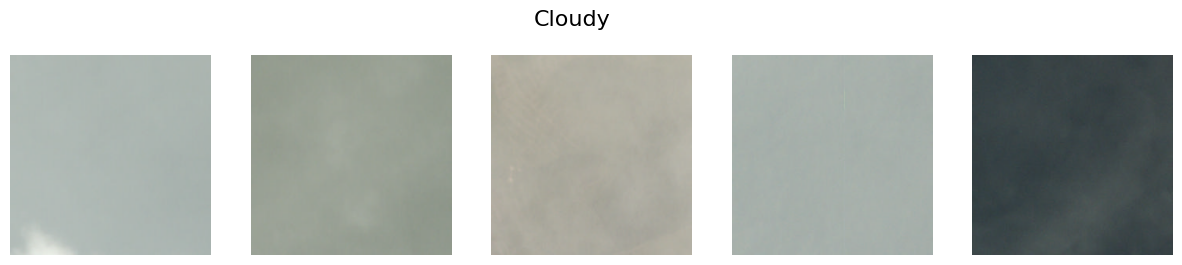

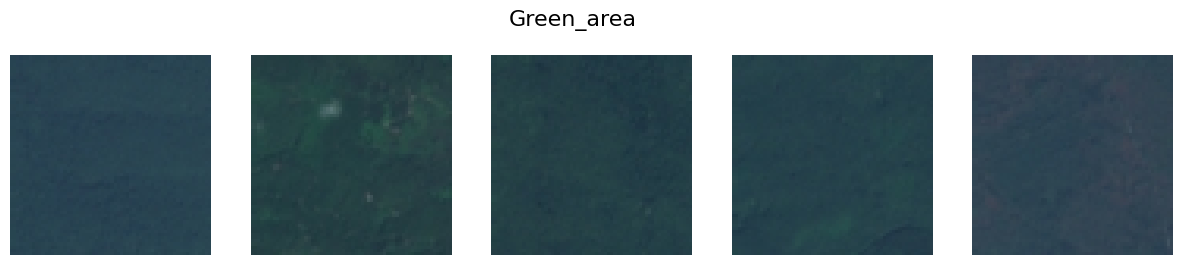

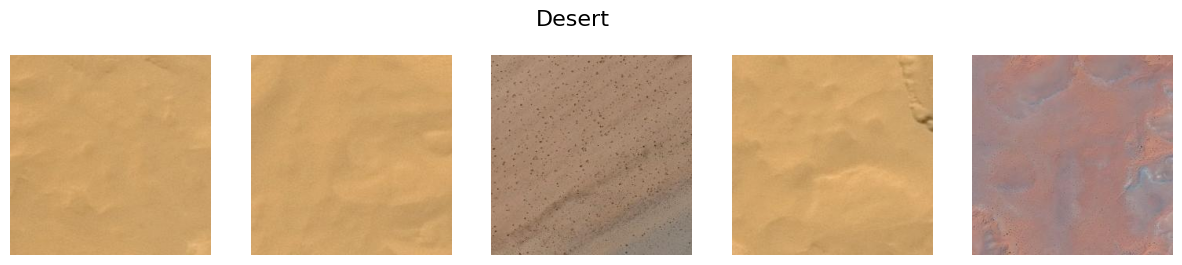

In [7]:
folder_path = "/content/data"
categories = os.listdir(folder_path)
for category in categories:
    category_path = os.path.join(folder_path, category)
    image_files = os.listdir(category_path)
    random_images = random.sample(image_files, 5)
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(category.capitalize(), fontsize=16)
    for i, image_name in enumerate(random_images):
        image_path = os.path.join(category_path, image_name)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

plt.show()


In [8]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_data(self):
        data = []
        label_mapping = {'cloudy': 0, 'desert': 1, 'water': 2, 'green_area': 3}
        folders = os.listdir(self.folder_path)
        for folder in folders:
            folder_path = os.path.join(self.folder_path, folder)
            if os.path.isdir(folder_path):
                image_files = os.listdir(folder_path)
                for image_name in image_files:
                    image_path = os.path.join(folder_path, image_name)
                    label = label_mapping[folder]
                    data.append((image_path, label))
        return data

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

folder_path = "/content/data"

custom_dataset = CustomDataset(folder_path, transform=data_transform)
sample_image, sample_label = custom_dataset[6]
print("Sample Image Shape:", sample_image.shape)
print("Sample Label:", sample_label)


Sample Image Shape: torch.Size([3, 224, 224])
Sample Label: 2


In [9]:
batch_size = 32
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(custom_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#Model without freezing

In [22]:
from efficientnet_pytorch import EfficientNet

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()
        self.fc = nn.Linear(self.num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

model = EfficientNetB0()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



Loaded pretrained weights for efficientnet-b0


EfficientNetB0(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

Training the model

Epoch [1/10], Loss: 0.1120, Accuracy: 97.00%, Recall: 0.97, Precision: 0.97, F1-score: 0.97
Epoch [2/10], Loss: 0.0404, Accuracy: 98.58%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [3/10], Loss: 0.0235, Accuracy: 99.31%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [4/10], Loss: 0.0312, Accuracy: 98.93%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [5/10], Loss: 0.0166, Accuracy: 99.47%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [6/10], Loss: 0.0142, Accuracy: 99.62%, Recall: 1.00, Precision: 1.00, F1-score: 1.00
Epoch [7/10], Loss: 0.0052, Accuracy: 99.84%, Recall: 1.00, Precision: 1.00, F1-score: 1.00
Epoch [8/10], Loss: 0.0190, Accuracy: 99.42%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [9/10], Loss: 0.0134, Accuracy: 99.56%, Recall: 1.00, Precision: 1.00, F1-score: 1.00
Epoch [10/10], Loss: 0.0052, Accuracy: 99.87%, Recall: 1.00, Precision: 1.00, F1-score: 1.00


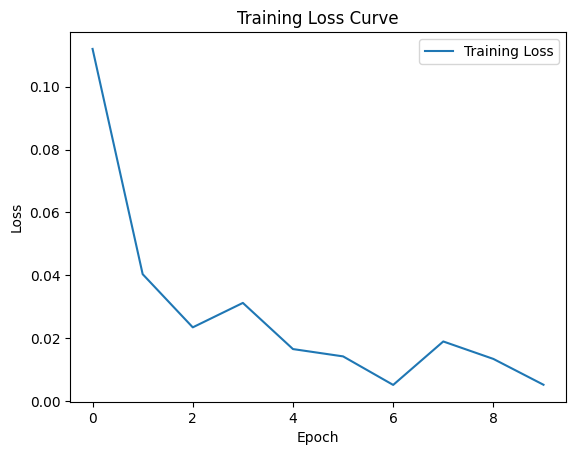

In [24]:
from sklearn.metrics import classification_report

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []

def train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    model.train()
    best_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_predictions = []
        epoch_labels = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            epoch_predictions.extend(predicted.tolist())
            epoch_labels.extend(labels.tolist())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        epoch_accuracy = accuracy_score(epoch_labels, epoch_predictions) * 100
        epoch_recall = recall_score(epoch_labels, epoch_predictions, average='macro')
        epoch_precision = precision_score(epoch_labels, epoch_predictions, average='macro')
        epoch_f1 = f1_score(epoch_labels, epoch_predictions, average='macro')

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Recall: {epoch_recall:.2f}, Precision: {epoch_precision:.2f}, F1-score: {epoch_f1:.2f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    return model

best_model = train_model(model, criterion, optimizer, train_loader, test_loader)


Testing the model

In [25]:
def test_model(model, test_loader):
    model.eval()
    test_losses = []
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.tolist())
            test_labels.extend(labels.tolist())

    test_accuracy = accuracy_score(test_labels, test_predictions) * 100
    test_loss = sum(test_losses) / len(test_losses)
    test_recall = recall_score(test_labels, test_predictions, average='macro')
    test_precision = precision_score(test_labels, test_predictions, average='macro')
    test_f1 = f1_score(test_labels, test_predictions, average='macro')

    print(f"Accuracy on the test set: {test_accuracy:.2f}%")
    print(f"Average loss on the test set: {test_loss:.4f}")
    print(f"Recall on the test set: {test_recall:.2f}")
    print(f"Precision on the test set: {test_precision:.2f}")
    print(f"F1-score on the test set: {test_f1:.2f}")
    print()
    target_names = ['cloudy', 'desert', 'water', 'green_area']
    print("Classification Report for the test set:")
    print(classification_report(test_labels, test_predictions, target_names=target_names))

test_model(best_model, test_loader)


Accuracy on the test set: 99.91%
Average loss on the test set: 0.0026
Recall on the test set: 1.00
Precision on the test set: 1.00
F1-score on the test set: 1.00

Classification Report for the test set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       301
      desert       1.00      1.00      1.00       219
       water       1.00      1.00      1.00       287
  green_area       1.00      1.00      1.00       320

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127



#Model with Freezing

In [14]:
from efficientnet_pytorch import EfficientNet
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()
        self.fc = nn.Linear(self.num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

model1 = EfficientNetB0()

for name, param in model1.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNetB0(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

Training the model

Epoch [1/10], Loss: 0.3321, Accuracy: 93.45%, Recall: 0.94, Precision: 0.94, F1-score: 0.94
Epoch [2/10], Loss: 0.1116, Accuracy: 97.58%, Recall: 0.98, Precision: 0.98, F1-score: 0.98
Epoch [3/10], Loss: 0.0737, Accuracy: 98.25%, Recall: 0.98, Precision: 0.98, F1-score: 0.98
Epoch [4/10], Loss: 0.0593, Accuracy: 98.65%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [5/10], Loss: 0.0622, Accuracy: 98.25%, Recall: 0.98, Precision: 0.98, F1-score: 0.98
Epoch [6/10], Loss: 0.0457, Accuracy: 98.65%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [7/10], Loss: 0.0433, Accuracy: 98.93%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [8/10], Loss: 0.0481, Accuracy: 98.51%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [9/10], Loss: 0.0410, Accuracy: 98.93%, Recall: 0.99, Precision: 0.99, F1-score: 0.99
Epoch [10/10], Loss: 0.0326, Accuracy: 99.22%, Recall: 0.99, Precision: 0.99, F1-score: 0.99


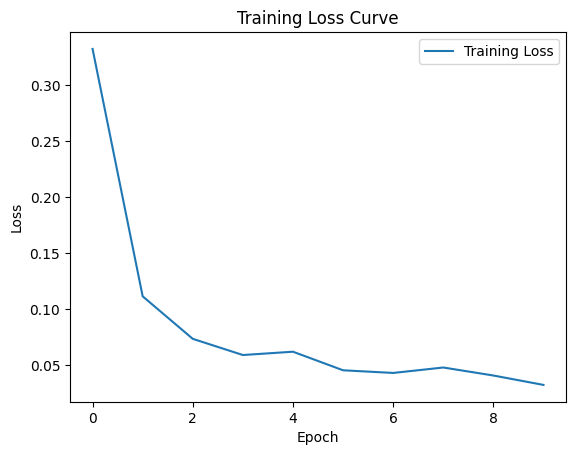

In [15]:
from sklearn.metrics import classification_report

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

train_losses = []
def train_model(model1, criterion, optimizer, train_loader, test_loader, num_epochs=10):
    model1.train()
    best_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_predictions = []
        epoch_labels = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            epoch_predictions.extend(predicted.tolist())
            epoch_labels.extend(labels.tolist())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        epoch_accuracy = accuracy_score(epoch_labels, epoch_predictions) * 100
        epoch_recall = recall_score(epoch_labels, epoch_predictions, average='macro')
        epoch_precision = precision_score(epoch_labels, epoch_predictions, average='macro')
        epoch_f1 = f1_score(epoch_labels, epoch_predictions, average='macro')

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Recall: {epoch_recall:.2f}, Precision: {epoch_precision:.2f}, F1-score: {epoch_f1:.2f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model1.state_dict(), 'best_model1.pth')

    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()
    return model1

best_model1 = train_model(model1, criterion, optimizer, train_loader, test_loader)


Test the model

In [19]:
def test_model(model1, test_loader):
    model1.eval()
    test_losses = []
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.tolist())
            test_labels.extend(labels.tolist())

    test_accuracy = accuracy_score(test_labels, test_predictions) * 100
    test_recall = recall_score(test_labels, test_predictions, average='macro')
    test_loss = sum(test_losses) / len(test_losses)
    test_precision = precision_score(test_labels, test_predictions, average='macro')
    test_f1 = f1_score(test_labels, test_predictions, average='macro')

    print(f"Accuracy on the test set: {test_accuracy:.2f}%")
    print(f"Recall on the test set: {test_recall:.2f}")
    print(f"Average loss on the test set: {test_loss:.4f}")
    print(f"Precision on the test set: {test_precision:.2f}")
    print(f"F1-score on the test set: {test_f1:.2f}")
    print()
    target_names = ['cloudy', 'desert', 'water', 'green_area']
    print("Classification Report for the test set:")
    print(classification_report(test_labels, test_predictions, target_names=target_names))

test_model(best_model1, test_loader)

Accuracy on the test set: 99.65%
Recall on the test set: 1.00
Average loss on the test set: 0.0114
Precision on the test set: 1.00
F1-score on the test set: 1.00

Classification Report for the test set:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       301
      desert       1.00      1.00      1.00       219
       water       0.99      1.00      0.99       287
  green_area       1.00      0.99      1.00       320

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127



#Saliency Map

Model without Freezing

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


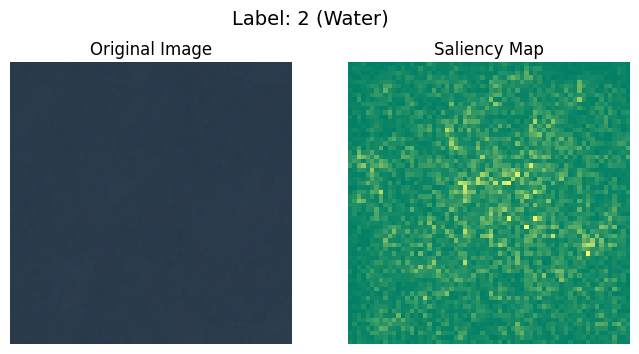

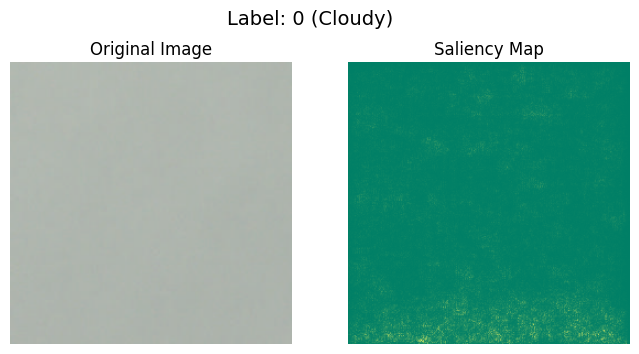

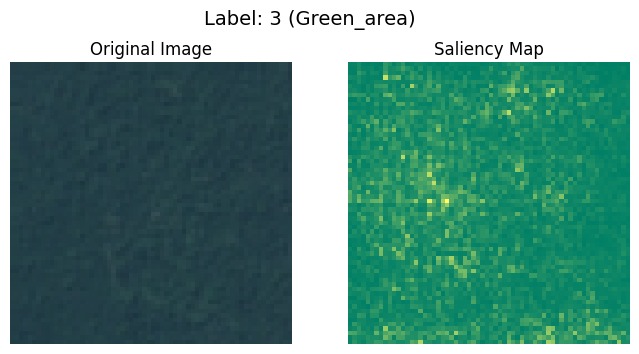

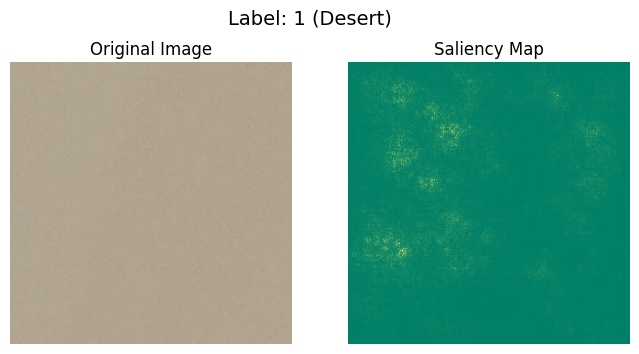

In [17]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()
        self.fc = nn.Linear(self.num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

def compute_saliency_map(model, image):
    model.eval()
    if image.shape[2] == 4:
        image = image[:, :, :3]
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    image_tensor.requires_grad_()
    output = model(image_tensor)
    target_class = torch.argmax(output)
    output[0, target_class].backward()
    saliency_map = torch.abs(image_tensor.grad[0]).max(0)[0]
    saliency_map = saliency_map.cpu().detach().numpy()
    return saliency_map


def visualize_saliency_maps(folder_path, model_path, device):
    model = EfficientNetB0().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    label_mapping = {'cloudy': 0, 'desert': 1, 'water': 2, 'green_area': 3}
    categories = os.listdir(folder_path)
    for category in categories:
        category_path = os.path.join(folder_path, category)
        image_files = os.listdir(category_path)
        random_image = random.choice(image_files)
        image_path = os.path.join(category_path, random_image)
        image = mpimg.imread(image_path)
        saliency_map = compute_saliency_map(model, image)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='summer')
        plt.title('Saliency Map')
        plt.axis('off')
        label = label_mapping[category]
        plt.suptitle(f'Label: {label} ({category.capitalize()})', fontsize=14)
        plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "/content/data"
model_path = "/content/best_model.pth"

visualize_saliency_maps(folder_path, model_path, device)


Model with Freezing

Loaded pretrained weights for efficientnet-b0


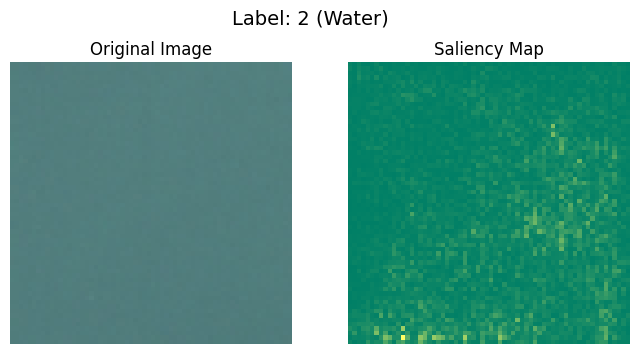

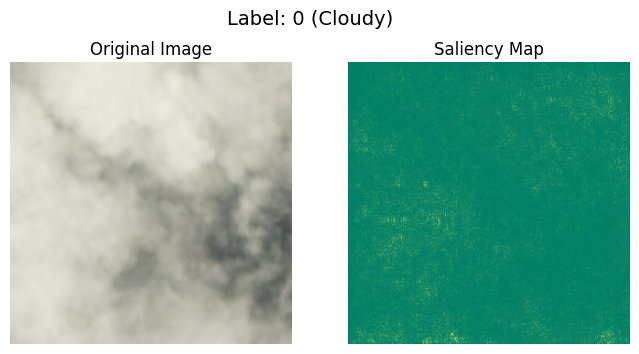

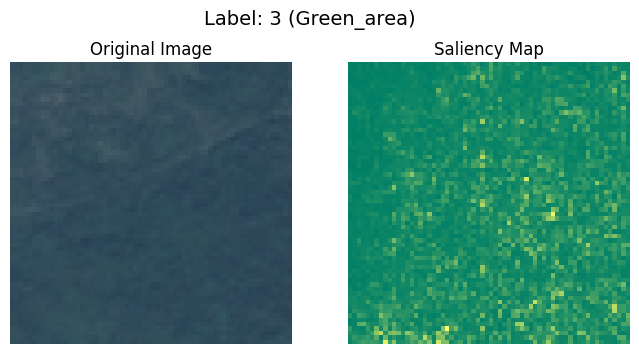

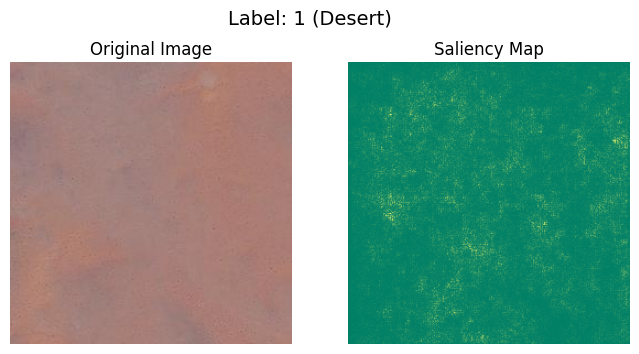

In [18]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNetB0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        self.num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Identity()
        self.fc = nn.Linear(self.num_ftrs, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

def compute_saliency_map(model, image):
    model.eval()
    if image.shape[2] == 4:
        image = image[:, :, :3]
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    image_tensor.requires_grad_()
    output = model(image_tensor)
    target_class = torch.argmax(output)
    output[0, target_class].backward()
    saliency_map = torch.abs(image_tensor.grad[0]).max(0)[0]
    saliency_map = saliency_map.cpu().detach().numpy()
    return saliency_map

def visualize_saliency_maps(model, model_path, device, folder_path, label_mapping):
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    categories = os.listdir(folder_path)
    for category in categories:
        category_path = os.path.join(folder_path, category)
        image_files = os.listdir(category_path)
        random_image = random.choice(image_files)
        image_path = os.path.join(category_path, random_image)

        image = mpimg.imread(image_path)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        saliency_map = compute_saliency_map(model, image)
        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='summer')
        plt.title('Saliency Map')
        plt.axis('off')

        label = label_mapping[category]
        plt.suptitle(f'Label: {label} ({category.capitalize()})', fontsize=14)

        plt.show()

model1 = EfficientNetB0()
for name, param in model1.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

model_path = "/content/best_model1.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "/content/data"
label_mapping = {'cloudy': 0, 'desert': 1, 'water': 2, 'green_area': 3}

visualize_saliency_maps(model1, model_path, device, folder_path, label_mapping)


#Explanation for the difference in metric values


1. Performance on Test Data:
   - Model with Freezing: Since the model just adjusts the final layer while keeping the pre-trained features fixed, it may perform slightly worse on the training set compared to the model without freezing.
   - Model without Freezing: This model has higher accuracy on the training set due to its ability to update all parameters and learn task-specific features.



2. Feature Representation:
   - Training the model without freezing helps the model to learn rich and good representations directly from the raw data, resulting in better discrimination between classes in the target dataset.
   - The original model, with its parameters frozen during most of the training process, might not fully capture the specific characteristics and complexities of the target dataset, leading to slightly lower performance.

